In [2]:
from osier import DispatchModel, LogicDispatchModel, CapacityExpansion
from osier import annual_emission, total_cost
from unyt import MW

import osier.tech_library as lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

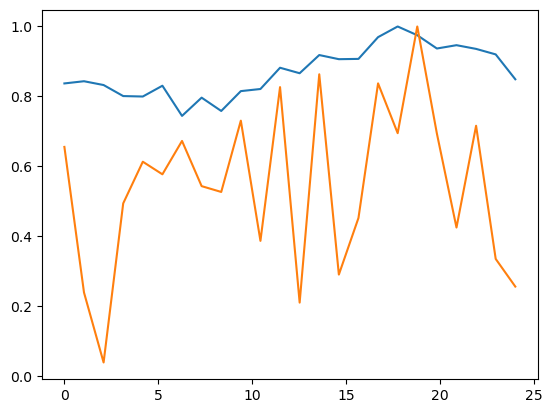

In [3]:
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
day_hours = 24  # hours per day
year_hours = 8760  # hours per year
total_demand = 185  # [MWh], sets the total demand [units of energy]
rng = np.random.default_rng(seed=1234)
squish = 0.5

n_days = 1  # days to model
N = day_hours * n_days  # total number of time steps

hours = np.linspace(0, N, N)
y = np.sin((hours * np.pi / year_hours + phase_shift)) + np.ones(len(hours)) * (base_shift + 1) * squish

demand = (np.sin((hours * np.pi / day_hours * 2 + phase_shift))
          * -1 + np.ones(N) * (base_shift + 1)) * 0.25 + y

noise = rng.normal(size=N)*0.05
demand += noise

demand = demand / demand.max()
wind_speed = rng.weibull(a=2, size=N)
wind_speed /= wind_speed.max()

plt.plot(hours, demand)
plt.plot(hours, wind_speed)

In [4]:
%%time
algorithm = NSGA2(pop_size=20)
problem = CapacityExpansion(technology_list = [lib.wind, lib.natural_gas, lib.battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost, annual_emission],
                            # model_engine='logical',
                            model_engine='optimal',
                            solver='appsi_highs',
                            )  # the objectives must be passed as a LIST of functions!

# define the problem by passing the starmap interface of the thread pool
# problem = MyProblem(elementwise_runner=runner)

res = minimize(problem, algorithm, termination=("n_gen", 10), seed=1, verbose=True, save_history=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      8 |             - |             -
     2 |       40 |      7 |  0.1841902220 |         nadir
     3 |       60 |      9 |  0.2734886643 |         ideal
     4 |       80 |      8 |  0.0039840007 |         ideal
     5 |      100 |     14 |  0.0511123078 |             f
     6 |      120 |     20 |  0.0309770309 |         ideal
     7 |      140 |     20 |  0.0350535586 |         ideal
     8 |      160 |     20 |  0.0046491063 |         ideal
     9 |      180 |     20 |  0.0056290621 |         ideal
    10 |      200 |     20 |  0.0375665456 |         ideal
CPU times: user 1min, sys: 540 ms, total: 1min 1s
Wall time: 1min 1s


In [28]:
%%time
algorithm = NSGA2(pop_size=20)
problem = CapacityExpansion(technology_list = [lib.wind, lib.natural_gas, lib.battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost, annual_emission],
                            model_engine='logical',
                            # model_engine='optimal',
                            solver='appsi_highs',
                            )  # the objectives must be passed as a LIST of functions!

# define the problem by passing the starmap interface of the thread pool
# problem = MyProblem(elementwise_runner=runner)

res = minimize(problem, algorithm, termination=("n_gen", 10), seed=1, verbose=True, save_history=True)

KeyboardInterrupt: 

In [ ]:
# initialize the thread pool and create the runner
n_threads = 4
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)
algorithm = NSGA2(pop_size=4)
problem = CapacityExpansion(technology_list = [lib.wind, lib.natural_gas, lib.battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost, annual_emission],
                            model_engine='optimal',
                            solver='appsi_highs',
                            elementwise_runner=runner)  # the objectives must be passed as a LIST of functions!

# define the problem by passing the starmap interface of the thread pool
# problem = MyProblem(elementwise_runner=runner)

res = minimize(problem, algorithm, termination=("n_gen", 10), seed=1, verbose=True, save_history=True)
print('Threads:', res.exec_time)

pool.close()